# Dependable AI - Minor 1

## Implementation of the Research Paper: "Sparse and Imperceivable Adversarial Attacks" by Francesco Croce and Matthias Hein - University of Tubingen

    Ayush Abrol B20AI052

---

### Importing necessary libraries and modules

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
torch.cuda.empty_cache()
import torchvision
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import warnings
warnings.filterwarnings('ignore')
import argparse

### Setting up the environment to GPU

In [31]:
device = torch.device("cuda"  if  torch.cuda.is_available()  else  "cpu")
device

device(type='cuda')

### Clearing my GPU cache

In [32]:
torch.cuda.empty_cache()

### Implementing some utility functions

#### Calcualting Logits

In [33]:
def get_logits(model, x_nat):   # x_nat is a numpy array of shape (N, 32, 32, 3)
    x = torch.from_numpy(x_nat).permute(0, 3, 1, 2).float() # Converting to torch tensor and permute dimensions
    
    with torch.no_grad(): 
        output = model(x.to(device)) # Forward pass
    
    return output.cpu().numpy() # Return logits

#### Function to return the predictions of the model

In [34]:
def get_predictions(model, x_nat, y_nat): 
    x = torch.from_numpy(x_nat).permute(0, 3, 1, 2).float()
    y = torch.from_numpy(y_nat)
    with torch.no_grad():
        output = model(x.to(device))
    return (output.cpu().max(dim=-1)[1] == y).numpy()

#### Function to return the predictions and the gradients of the model using Cross Entropy Loss

In [35]:
def get_predictions_and_gradients(model, x_nat, y_nat):
    x = torch.from_numpy(x_nat).permute(0, 3, 1, 2).float()
    x.requires_grad_()
    y = torch.from_numpy(y_nat)

    with torch.enable_grad():
        output = model(x.to(device))
        loss = nn.CrossEntropyLoss()(output, y.to(device))

    grad = torch.autograd.grad(loss, x)[0]
    grad = grad.detach().permute(0, 2, 3, 1).numpy()

    pred = (output.detach().cpu().max(dim=-1)[1] == y).numpy()

    return pred, grad

### Loading dataset function

Note: We can use CIFAR10, MNIST or the FashionMNIST dataset

In [36]:
def load_data(dataset, n_examples, data_dir='./data'):
    if dataset == 'cifar10':
        transform_chain = transforms.Compose([transforms.ToTensor()])
        item = datasets.CIFAR10(root=data_dir, train=False, transform=transform_chain, download=True)
        test_loader = torch.utils.data.DataLoader(item, batch_size=1, shuffle=False, num_workers=0)
    
    elif dataset == 'mnist':
        transform_chain = transforms.Compose([transforms.Grayscale(3),
                                              transforms.ToTensor(),])
        image_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform_chain, download=True)
        test_loader = torch.utils.data.DataLoader(image_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    elif dataset == 'FashionMNIST':
        transform_chain = transforms.Compose([transforms.Grayscale(3),
                                              transforms.ToTensor(),])
        image_dataset = datasets.FashionMNIST(root=data_dir, train=False, transform=transform_chain, download=True)
        test_loader = torch.utils.data.DataLoader(image_dataset, batch_size=1, shuffle=False, num_workers=0)
    
    x_test = torch.cat([x for (x, y) in test_loader], 0)[:n_examples].permute(0, 2, 3, 1)  # (N, 32, 32, 3)
    y_test = torch.cat([y for (x, y) in test_loader], 0)[:n_examples]
    
    return x_test.numpy(), y_test.numpy()

### Creating ResNet models

#### Basic ResNet Block (Residual Block) with Batch Normalization and ReLU

In [37]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

#### BottleNeck ResNet Block (Residual Block) with Batch Normalization and ReLU

In [38]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, 
                               bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

#### ResNet Model which can be used to create ResNet models of different depths.

In [39]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

#### Now we will create ResNet models of different depths using Basic ResNet Blocks and BottleNeck ResNet Blocks

In [40]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

#### Defining the test function to test the model with ResNet18.

In [41]:
def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

### Defining the CornerSearch attacks

#### One-pixel modifications to the image using the CornerSearch attack

In [42]:
def onepixel_perturbation(attack, orig_x, pos, sigma):
  ''' returns a batch with the possible perturbations of the pixel in position pos '''
    
  if attack.type_attack == 'L0':
    if orig_x.shape[-1] == 3:
      batch_x = np.tile(orig_x,(8,1,1,1))
      t = np.zeros([3])
      for counter in range(8):
        t2 = counter + 0
        for c in range(3):
          t[c] = t2 % 2
          t2 = (t2 - t[c])/2
        batch_x[counter,pos[0],pos[1]] = t.astype(np.float32)
    elif orig_x.shape[-1] == 1:
      batch_x = np.tile(orig_x,(2,1,1,1))
      batch_x[0,pos[0],pos[1],0] = 0.0
      batch_x[1,pos[0],pos[1],0] = 1.0
  
  elif attack.type_attack == 'L0+Linf':
    if orig_x.shape[-1] == 3:
      batch_x = np.tile(orig_x,(8,1,1,1))
      t = np.zeros([3])
      for counter in range(8):
        t2 = counter + 0
        for c in range(3):
          t3 = t2 % 2
          t[c] = (t3*2.0 - 1.0)*attack.epsilon
          t2 = (t2 - t3)/2
        batch_x[counter,pos[0],pos[1]] = np.clip(t.astype(np.float32) + orig_x[pos[0],pos[1]], 0.0, 1.0)
    elif orig_x.shape[-1] == 1:
      batch_x = np.tile(orig_x,(2,1,1,1))
      batch_x[0,pos[0],pos[1],0] = np.clip(batch_x[0,pos[0],pos[1],0] - attack.epsilon, 0.0, 1.0)
      batch_x[1,pos[0],pos[1],0] = np.clip(batch_x[1,pos[0],pos[1],0] + attack.epsilon, 0.0, 1.0)
  
  elif attack.type_attack == 'L0+sigma':
    batch_x = np.tile(orig_x,(2,1,1,1))
    if orig_x.shape[-1] == 3:
      batch_x[0,pos[0],pos[1]] = np.clip(batch_x[0,pos[0],pos[1]]*(1.0 - attack.kappa*sigma[pos[0],pos[1]]), 0.0, 1.0)
      batch_x[1,pos[0],pos[1]] = np.clip(batch_x[0,pos[0],pos[1]]*(1.0 + attack.kappa*sigma[pos[0],pos[1]]), 0.0, 1.0)
    
    elif orig_x.shape[-1] == 1:
      batch_x[0,pos[0],pos[1]] = np.clip(batch_x[0,pos[0],pos[1]] - attack.kappa*sigma[pos[0],pos[1]], 0.0, 1.0)
      batch_x[1,pos[0],pos[1]] = np.clip(batch_x[0,pos[0],pos[1]] + attack.kappa*sigma[pos[0],pos[1]], 0.0, 1.0)
    
  else:
    raise ValueError('unknown attack')
  
  return batch_x

#### Returning the batch of images with the one-pixel modifications using the CornerSearch attack

In [43]:
def onepixel_perturbation_image(attack, orig_x, sigma):
  ''' returns a batch with all the possible perturbations of the image orig_x '''
  
  n_channels = orig_x.shape[-1]
  assert n_channels in [1, 3]
  n_corners = 2**n_channels if attack.type_attack in ['L0', 'L0+Linf'] else 2
  
  batch_x = np.zeros([n_corners*orig_x.shape[0]*orig_x.shape[1], orig_x.shape[0], orig_x.shape[1], orig_x.shape[2]])
  for counter in range(orig_x.shape[0]):
      for counter2 in range(orig_x.shape[1]):
        batch_x[(counter*orig_x.shape[0]+counter2)*n_corners:(counter*orig_x.shape[1]+counter2)*n_corners+n_corners] = np.clip(onepixel_perturbation(attack, orig_x, [counter,counter2], sigma), 0.0, 1.0)
  
  return batch_x

#### Returning the position and the perturbation given the index of an image of the batch of all the possible perturbations

In [44]:
def flat2square(attack, ind):
  ''' returns the position and the perturbation given the index of an image
      of the batch of all the possible perturbations '''
  
  if attack.type_attack in ['L0', 'L0+Linf']:
    if attack.shape_img[-1] == 3:
      new_pixel = ind % 8
      ind = (ind - new_pixel)//8
      c = ind % attack.shape_img[1]
      r = (ind - c)//attack.shape_img[1]
      t = np.zeros([ind.shape[0],3])
      for counter in range(3):
        t[:,counter] = new_pixel % 2
        new_pixel = (new_pixel - t[:,counter])/2
    elif attack.shape_img[-1] == 1:
      t = ind % 2
      ind = (ind-t)//2
      c = ind % attack.shape_img[1]
      r = (ind-c)//attack.shape_img[1]
  
  elif attack.type_attack == 'L0+sigma':
      t = ind % 2
      c = ((ind - t)//2) % attack.shape_img[1]
      r = ((ind - t)//2 - c)//attack.shape_img[1]
    
  return r, c, t

#### Creating n_iter images which differ from original in at most k pixels

In [45]:
def npixels_perturbation(attack, orig_x, ind, k, sigma):
  ''' creates n_iter images which differ from orig_x in at most k pixels '''
  
  # sampling the n_iter k-pixels perturbations
  ind2 = np.random.randint(0, attack.n_max**2, (attack.n_iter, k))
  ind2 = attack.n_max - np.floor(ind2**0.5).astype(int) - 1
  
  # creating the n_iter k-pixels perturbed images
  batch_x = np.tile(orig_x,(attack.n_iter,1,1,1))
  if attack.type_attack == 'L0':
    for counter in range(attack.n_iter):
      p11, p12, d1 = flat2square(attack, ind[ind2[counter]])
      batch_x[counter,p11,p12] = d1 + 0 if attack.shape_img[-1] == 3 else np.expand_dims(d1 + 0, 1)
  
  elif attack.type_attack == 'L0+Linf':
    for counter in range(attack.n_iter):
      p11, p12, d1 = flat2square(attack, ind[ind2[counter]])
      d1 = d1 + 0 if attack.shape_img[-1] == 3 else np.expand_dims(d1 + 0, 1)
      batch_x[counter,p11,p12] = np.clip(batch_x[counter,p11,p12]+(2.0*d1 - 1.0)*attack.epsilon, 0.0, 1.0)
  
  elif attack.type_attack == 'L0+sigma':
    for counter in range(attack.n_iter):
      p11, p12, d1 = flat2square(attack, ind[ind2[counter]])
      d1 = np.expand_dims(d1,1)
      if attack.shape_img[-1] == 3: batch_x[counter,p11,p12] = np.clip(batch_x[counter,p11,p12] - attack.kappa*sigma[p11,p12]*(1-d1) + attack.kappa*sigma[p11,p12]*d1, 0.0, 1.0)
      elif attack.shape_img[-1] == 1: batch_x[counter,p11,p12] = np.clip(batch_x[counter,p11,p12] - attack.kappa*sigma[p11,p12]*(1-d1) + attack.kappa*sigma[p11,p12]*d1, 0.0, 1.0)
      
  return batch_x

#### Creating the sigma-map for a batch x. 

Note: This map would be used in both CornerSearch and PGD attacks.

In [46]:
def sigma_map(x):
  ''' creates the sigma-map for the batch x '''
  
  sh = [4]
  sh.extend(x.shape)
  t = np.zeros(sh)
  t[0,:,:-1] = x[:,1:]
  t[0,:,-1] = x[:,-1]
  t[1,:,1:] = x[:,:-1]
  t[1,:,0] = x[:,0]
  t[2,:,:,:-1] = x[:,:,1:]
  t[2,:,:,-1] = x[:,:,-1]
  t[3,:,:,1:] = x[:,:,:-1]
  t[3,:,:,0] = x[:,:,0]

  mean1 = (t[0] + x + t[1])/3
  sd1 = np.sqrt(((t[0]-mean1)**2 + (x-mean1)**2 + (t[1]-mean1)**2)/3)

  mean2 = (t[2] + x + t[3])/3
  sd2 = np.sqrt(((t[2]-mean2)**2 + (x-mean2)**2 + (t[3]-mean2)**2)/3)

  sd = np.minimum(sd1, sd2)
  sd = np.sqrt(sd)
  
  return sd

#### Defining the class CornerSearch which would be used to create the CornerSearch attack

In [47]:
class CSattack():
  def __init__(self, model, args):
    self.model = model
    self.type_attack = args['type_attack'] # 'L0', 'L0+Linf', 'L0+sigma'
    self.n_iter = args['n_iter']           # number of iterations (N_iter in the paper)
    self.n_max = args['n_max']             # the modifications for k-pixels perturbations are sampled among the best n_max (N in the paper)
    self.epsilon = args['epsilon']         # for L0+Linf, the bound on the Linf-norm of the perturbation
    self.kappa = args['kappa']             # for L0+sigma (see kappa in the paper), larger kappa means easier and more visible attacks
    self.k = args['sparsity']              # maximum number of pixels that can be modified (k_max in the paper)
    self.size_incr = args['size_incr']     # size of progressive increment of sparsity levels to check  
  
  def perturb(self, x_nat, y_nat):
    adv = np.copy(x_nat)
    fl_success = np.ones([x_nat.shape[0]])
    self.shape_img = x_nat.shape[1:]
    self.sigma = sigma_map(x_nat)
    self.n_classes = 10
    self.n_corners = 2**self.shape_img[2] if self.type_attack in ['L0', 'L0+Linf'] else 2
    #corr_pred = sess.run(self.model.correct_prediction, {self.model.x_input: x_nat, self.model.y_input: y_nat})
    corr_pred = get_predictions(self.model, x_nat, y_nat)
    bs = self.shape_img[0]*self.shape_img[1]
    
    for c in range(x_nat.shape[0]):
      if corr_pred[c]:
        sigma = np.copy(self.sigma[c])
        batch_x = onepixel_perturbation_image(self, x_nat[c], sigma)
        batch_y = np.squeeze(y_nat[c])
        logit_2 = np.zeros([batch_x.shape[0], self.n_classes])
        found = False
        
        # checks one-pixels modifications
        for counter in range(self.n_corners):
          #logit_2[counter*bs:(counter+1)*bs], pred = sess.run([self.model.y, self.model.correct_prediction], feed_dict={self.model.x_input: batch_x[counter*bs:(counter+1)*bs], self.model.y_input: np.tile(batch_y,(bs))})
          logit_2[counter*bs:(counter+1)*bs] = get_logits(self.model, batch_x[counter*bs:(counter+1)*bs])
          pred = logit_2[counter*bs:(counter+1)*bs].argmax(axis=-1) == np.tile(batch_y,(bs))
          if not pred.all() and not found:
            ind_adv = np.where(pred.astype(int)==0)
            adv[c] = batch_x[counter*bs + ind_adv[0][0]]
            found = True
            print('Point {} - adversarial example found changing 1 pixel'.format(c))
        
        # creates the orderings
        t1 = np.copy(logit_2[:, batch_y])
        logit_2[:, batch_y] = -1000.0*np.ones(np.shape(logit_2[:, batch_y]))
        t2 = np.amax(logit_2, axis=1)
        t3 = t1 - t2
        logit_3 = np.tile(np.expand_dims(t1,axis=1),(1,self.n_classes))-logit_2
        logit_3[:, batch_y] = t3
        ind = np.argsort(logit_3, axis=0)
        
        # checks multiple-pixels modifications
        for n3 in range(1 + self.size_incr, self.k + 1, self.size_incr):
          if not found:
             for c2 in range(self.n_classes):
               if not found:
                 ind_cl = np.copy(ind[:, c2])

                 batch_x = npixels_perturbation(self, x_nat[c], ind_cl, n3, sigma)
                 #pred = sess.run(self.model.correct_prediction, feed_dict={self.model.x_input: batch_x, self.model.y_input: np.tile(batch_y,(batch_x.shape[0]))})
                 pred = get_predictions(self.model, batch_x, np.tile(batch_y,(batch_x.shape[0])))
                 
                 if np.sum(pred.astype(np.int32)) < self.n_iter and not found:
                   found = True
                   ind_adv = np.where(pred.astype(int)==0)
                   adv[c] = batch_x[ind_adv[0][0]]
                   print('Point {} - adversarial example found changing {} pixels'.format(c, np.sum(np.amax(np.abs(adv[c] - x_nat[c]) > 1e-10, axis=-1), axis=(0,1))))
        
        if not found:
          fl_success[c] = 0
          print('Point {} - adversarial example not found'.format(c))
      
      else:
        print('Point {} - misclassified'.format(c))
    
    pixels_changed = np.sum(np.amax(np.abs(adv - x_nat) > 1e-10, axis=-1), axis=(1,2))
    print('Pixels changed: ', pixels_changed)
    #print('attack successful: ', fl_success)
    #print('attack successful: {:.2f}%'.format((1.0 - np.mean(fl_success))*100.0))
    #corr_pred = sess.run(self.model.correct_prediction, {self.model.x_input: adv, self.model.y_input: y_nat})
    corr_pred = get_predictions(self.model, adv, y_nat)
    print('Robust accuracy at {} pixels: {:.2f}%'.format(self.k, np.sum(corr_pred)/x_nat.shape[0]*100.0))
    print('Maximum perturbation size: {:.5f}'.format(np.amax(np.abs(adv - x_nat))))
    
    return adv, pixels_changed, fl_success

### PGD attacks (Projected Gradient Descent Attacks)

#### Projection of the batch y to a batch x such that: 
    1. Each image of the batch x has at most k pixels with non-zero channels 
    2. - lb <= x <= ub

In [48]:
def project_L0_box(y, k, lb, ub):
  ''' projection of the batch y to a batch x such that:
        - each image of the batch x has at most k pixels with non-zero channels
        - lb <= x <= ub '''
      
  x = np.copy(y)
  p1 = np.sum(x**2, axis=-1)
  p2 = np.minimum(np.minimum(ub - x, x - lb), 0)
  p2 = np.sum(p2**2, axis=-1)
  p3 = np.sort(np.reshape(p1-p2, [p2.shape[0],-1]))[:,-k]
  x = x*(np.logical_and(lb <=x, x <= ub)) + lb*(lb > x) + ub*(x > ub)
  x *= np.expand_dims((p1 - p2) >= p3.reshape([-1, 1, 1]), -1)
    
  return x

#### Projection of the batch y to a batch x such that: 
    1. 0 <= x <= 1 
    2. Each image of the batch x differs from the corresponding one of x_nat in at most k pixels
    3. (1 - kappa*sigma)*x_nat <= x <= (1 + kappa*sigma)*x_nat

In [49]:
def project_L0_sigma(y, k, sigma, kappa, x_nat):
  ''' projection of the batch y to a batch x such that:
        - 0 <= x <= 1
        - each image of the batch x differs from the corresponding one of
          x_nat in at most k pixels
        - (1 - kappa*sigma)*x_nat <= x <= (1 + kappa*sigma)*x_nat '''
  
  x = np.copy(y)
  p1 = 1.0/np.maximum(1e-12, sigma)*(x_nat > 0).astype(float) + 1e12*(x_nat == 0).astype(float)
  p2 = 1.0/np.maximum(1e-12, sigma)*(1.0/np.maximum(1e-12, x_nat) - 1)*(x_nat > 0).astype(float) + 1e12*(x_nat == 0).astype(float) + 1e12*(sigma == 0).astype(float)
  lmbd_l = np.maximum(-kappa, np.amax(-p1, axis=-1, keepdims=True))
  lmbd_u = np.minimum(kappa, np.amin(p2, axis=-1, keepdims=True))
  
  lmbd_unconstr = np.sum((y - x_nat)*sigma*x_nat, axis=-1, keepdims=True)/np.maximum(1e-12, np.sum((sigma*x_nat)**2, axis=-1, keepdims=True))
  lmbd = np.maximum(lmbd_l, np.minimum(lmbd_unconstr, lmbd_u))
  
  p12 = np.sum((y - x_nat)**2, axis=-1, keepdims=True)
  p22 = np.sum((y - (1 + lmbd*sigma)*x_nat)**2, axis=-1, keepdims=True)
  p3 = np.sort(np.reshape(p12 - p22, [x.shape[0],-1]))[:,-k]
  
  x  = x_nat + lmbd*sigma*x_nat*((p12 - p22) >= p3.reshape([-1, 1, 1, 1]))
  
  return x

#### PGD attack wrt L0-norm + box constraints. It returns adversarial examples (if found) adv for the images x_nat, with correct labels y_nat, such that:

    1. Each image of the batch adv differs from the corresponding one of x_nat in at most k pixels
    2. - lb <= adv - x_nat <= ub
    3. It returns also a vector of flags where 1 means no adversarial example found (in this case the original image is returned in adv).

In [50]:
def perturb_L0_box(attack, x_nat, y_nat, lb, ub):
  ''' PGD attack wrt L0-norm + box constraints
  
      it returns adversarial examples (if found) adv for the images x_nat, with correct labels y_nat,
      such that:
        - each image of the batch adv differs from the corresponding one of
          x_nat in at most k pixels
        - lb <= adv - x_nat <= ub
      
      it returns also a vector of flags where 1 means no adversarial example found
      (in this case the original image is returned in adv) '''
  
  if attack.rs:
    x2 = x_nat + np.random.uniform(lb, ub, x_nat.shape)
    x2 = np.clip(x2, 0, 1)
  else:
    x2 = np.copy(x_nat)
      
  adv_not_found = np.ones(y_nat.shape)
  adv = np.zeros(x_nat.shape)

  for i in range(attack.num_steps):
    if i > 0:
      #pred, grad = sess.run([attack.model.correct_prediction, attack.model.grad], feed_dict={attack.model.x_input: x2, attack.model.y_input: y_nat})
      pred, grad = get_predictions_and_gradients(attack.model, x2, y_nat)
      adv_not_found = np.minimum(adv_not_found, pred.astype(int))
      adv[np.logical_not(pred)] = np.copy(x2[np.logical_not(pred)])
      
      grad /= (1e-10 + np.sum(np.abs(grad), axis=(1,2,3), keepdims=True))
      x2 = np.add(x2, (np.random.random_sample(grad.shape)-0.5)*1e-12 + attack.step_size * grad, casting='unsafe')
      
    x2 = x_nat + project_L0_box(x2 - x_nat, attack.k, lb, ub)
    
  return adv, adv_not_found

#### PGD attack wrt L0-norm + sigma-map constraints. It returns adversarial examples (if found) adv for the images x_nat, with correct labels y_nat, such that:

    1. each image of the batch adv differs from the corresponding one of x_nat in at most k pixels
    2. (1 - kappa*sigma)*x_nat <= adv <= (1 + kappa*sigma)*x_nat
    3. It returns also a vector of flags where 1 means no adversarial example found (in this case the original image is returned in adv)

In [51]:
def perturb_L0_sigma(attack, x_nat, y_nat):
  ''' PGD attack wrt L0-norm + sigma-map constraints
  
      it returns adversarial examples (if found) adv for the images x_nat, with correct labels y_nat,
      such that:
        - each image of the batch adv differs from the corresponding one of
          x_nat in at most k pixels
        - (1 - kappa*sigma)*x_nat <= adv <= (1 + kappa*sigma)*x_nat
      
      it returns also a vector of flags where 1 means no adversarial example found
      (in this case the original image is returned in adv) '''
  
  if attack.rs:
    x2 = x_nat + np.random.uniform(-attack.kappa, attack.kappa, x_nat.shape)
    x2 = np.clip(x2, 0, 1)
  else:
    x2 = np.copy(x_nat)
      
  adv_not_found = np.ones(y_nat.shape)
  adv = np.zeros(x_nat.shape)

  for i in range(attack.num_steps):
    if i > 0:
      #pred, grad = sess.run([attack.model.correct_prediction, attack.model.grad], feed_dict={attack.model.x_input: x2, attack.model.y_input: y_nat})
      pred, grad = get_predictions_and_gradients(attack.model, x2, y_nat)
      adv_not_found = np.minimum(adv_not_found, pred.astype(int))
      adv[np.logical_not(pred)] = np.copy(x2[np.logical_not(pred)])
      
      grad /= (1e-10 + np.sum(np.abs(grad), axis=(1,2,3), keepdims=True))
      x2 = np.add(x2, (np.random.random_sample(grad.shape)-0.5)*1e-12 + attack.step_size * grad, casting='unsafe')
      
    x2 = project_L0_sigma(x2, attack.k, attack.sigma, attack.kappa, x_nat)
    
  return adv, adv_not_found

#### Defining the class PGD attack which would be used to create the PGD attack using L0-norm + box constraints, L0-norm + L_inf constraints and L0-norm + sigma-map constraints.

In [52]:
class PGDattack():
  def __init__(self, model, args):
    self.model = model
    self.type_attack = args['type_attack'] # 'L0', 'L0+Linf', 'L0+sigma'
    self.num_steps = args['num_steps']     # number of iterations of gradient descent for each restart
    self.step_size = args['step_size']     # step size for gradient descent (\eta in the paper)
    self.n_restarts = args['n_restarts']   # number of random restarts to perform
    self.rs = True                         # random starting point
    self.epsilon = args['epsilon']         # for L0+Linf, the bound on the Linf-norm of the perturbation
    self.kappa = args['kappa']             # for L0+sigma (see kappa in the paper), larger kappa means easier and more visible attacks
    self.k = args['sparsity']              # maximum number of pixels that can be modified (k_max in the paper)
    
  def perturb(self, x_nat, y_nat):
    adv = np.copy(x_nat)
    
    if self.type_attack == 'L0+sigma': self.sigma = sigma_map(x_nat)
      
    for counter in range(self.n_restarts):
      if counter == 0:
        #corr_pred = sess.run(self.model.correct_prediction, {self.model.x_input: x_nat, self.model.y_input: y_nat})
        corr_pred = get_predictions(self.model, x_nat, y_nat)
        pgd_adv_acc = np.copy(corr_pred)
        
      if self.type_attack == 'L0':
        x_batch_adv, curr_pgd_adv_acc = perturb_L0_box(self, x_nat, y_nat, -x_nat, 1.0 - x_nat)
      
      elif self.type_attack == 'L0+Linf':
        x_batch_adv, curr_pgd_adv_acc = perturb_L0_box(self, x_nat, y_nat, np.maximum(-self.epsilon, -x_nat), np.minimum(self.epsilon, 1.0 - x_nat))
      
      elif self.type_attack == 'L0+sigma' and x_nat.shape[3] == 3:
        x_batch_adv, curr_pgd_adv_acc = perturb_L0_sigma(self, x_nat, y_nat)
      
      elif self.type_attack == 'L0+sigma' and x_nat.shape[3] == 1:
        x_batch_adv, curr_pgd_adv_acc = perturb_L0_box(self, x_nat, y_nat, np.maximum(-self.kappa*self.sigma, -x_nat), np.minimum(self.kappa*self.sigma, 1.0 - x_nat))
      
      
      pgd_adv_acc = np.minimum(pgd_adv_acc, curr_pgd_adv_acc)

      print("Restart {} - Robust accuracy: {}".format(counter + 1, np.sum(pgd_adv_acc)/x_nat.shape[0]))
      adv[np.logical_not(curr_pgd_adv_acc)] = x_batch_adv[np.logical_not(curr_pgd_adv_acc)]
    
    pixels_changed = np.sum(np.amax(np.abs(adv - x_nat) > 1e-10, axis=-1), axis=(1,2))
    print('Pixels changed: ', pixels_changed)
    #corr_pred = sess.run(self.model.correct_prediction, {self.model.x_input: adv, self.model.y_input: y_nat})
    corr_pred = get_predictions(self.model, adv, y_nat)
    print('Robust accuracy at {} pixels: {:.2f}%'.format(self.k, np.sum(corr_pred)/x_nat.shape[0]*100.0))
    print('Maximum perturbation size: {:.5f}'.format(np.amax(np.abs(adv - x_nat))))
    
    return adv, pixels_changed, pgd_adv_acc

### Running attacks on the models with CIFAR-10 dataset and evaluating the results

Note: In the research paper itself, the authors have used the CIFAR-100 dataset for their experiments with PyTorch implemtation of the code. Along with that, the authors have used CIFAR-10 and MNIST datasets for their experiments with Tensorflow implementation of the code. 

Therefore, I will be using CIFAR-10 dataset for my experiments and reproducing the results of the paper with CIFAR-10 dataset.

Later on, I will also try to reproduce the results of the paper with FashionMNIST dataset.

In [243]:
X_test, y_test = load_data(dataset = 'cifar10',n_examples = 100, data_dir = 'data')

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

Files already downloaded and verified
X_test shape:  (100, 32, 32, 3)
y_test shape:  (100,)


In [244]:
model = ResNet18().to(device)
ckpt = torch.load('./models/model_test.pt')
model.load_state_dict(ckpt)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

### Printing my GPU memory summary

In [245]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 14           |        cudaMalloc retries: 17        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  585441 KB |    3473 MB |    2151 GB |    2151 GB |
|       from large pool |  555008 KB |    3450 MB |    2142 GB |    2142 GB |
|       from small pool |   30433 KB |      33 MB |       9 GB |       9 GB |
|---------------------------------------------------------------------------|
| Active memory         |  585441 KB |    3473 MB |    2151 GB |    2151 GB |
|       from large pool |  555008 KB |    3450 MB |    2142 GB |

### PGD attack with L0 norm with k = 5 pixels

In [272]:
args = {'type_attack': 'L0',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': -1,
                'sparsity': 5}
attack = PGDattack(model, args)
adv_PGD, pixels_changed_PGD, pgd_adv_acc_PGD = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_PGD.npy', adv_PGD)

Restart 1 - Robust accuracy: 0.36
Restart 2 - Robust accuracy: 0.3
Restart 3 - Robust accuracy: 0.26
Restart 4 - Robust accuracy: 0.24
Restart 5 - Robust accuracy: 0.23
Pixels changed:  [5 5 5 5 5 5 5 5 5 5 5 0 5 0 0 5 5 5 5 0 5 5 5 0 5 5 5 0 5 5 5 5 5 5 0 5 5
 5 0 5 5 5 5 5 0 0 5 5 0 5 0 5 5 5 5 5 0 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 0 5 5 5 5 5 0 0 0 5 5 5 5 0 0 0 5 5 5 5 5 5 0 0 5]
Robust accuracy at 5 pixels: 23.00%
Maximum perturbation size: 1.00000


### PGD attack with L0 norm with k = 10 pixels

In [279]:
args = {'type_attack': 'L0',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': -1,
                'sparsity': 10}
attack = PGDattack(model, args)
adv_PGD_k10, pixels_changed_PGD_k10, pgd_adv_acc_PGD_k10 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_PGD_k10.npy', adv_PGD_k10)

Restart 1 - Robust accuracy: 0.12
Restart 2 - Robust accuracy: 0.07
Restart 3 - Robust accuracy: 0.06
Restart 4 - Robust accuracy: 0.05
Restart 5 - Robust accuracy: 0.05
Pixels changed:  [10 10 10 10 10 10 10 10 10 10 10  0 10 10 10 10 10 10 10 10 10 10 10  0
 10 10 10 10 10 10 10 10 10 10 10 10 10 10  0 10 10 10 10 10 10  0 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  0 10 10 10 10 10
 10 10 10 10]
Robust accuracy at 10 pixels: 5.00%
Maximum perturbation size: 1.00000


### PGD attack with L0 norm with changing pixels from 1-50 with n-restarts = 1

In [281]:
# PGD attack with L0 norm with changing pixels from 1-50 with n-restarts = 1
robust_acc_pgd_l0 = []
for k in range(1, 51):
    args = {'type_attack': 'L0',
                  'n_restarts': 1,
                  'num_steps': 100,
                  'step_size': 120000.0/255.0,
                  'kappa': -1,
                  'epsilon': -1,
                  'sparsity': k}
    attack = PGDattack(model, args)
    adv_val, pixels_changed_PGD_val, pgd_adv_acc_PGD_val = attack.perturb(X_test, y_test)
    robust_acc_pgd_l0.append((k, np.sum(pgd_adv_acc_PGD_val)/X_test.shape[0]))

Restart 1 - Robust accuracy: 0.82
Pixels changed:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Robust accuracy at 1 pixels: 82.00%
Maximum perturbation size: 0.94902
Restart 1 - Robust accuracy: 0.7
Pixels changed:  [0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0 0 2 0 2 0 0 0 0 0 0 0 2 2 2 2 0 0 2
 2 0 0 0 0 2 0 0 0 2 2 0 2 0 0 2 2 0 0 0 2 2 2 0 2 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 2 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0]
Robust accuracy at 2 pixels: 70.00%
Maximum perturbation size: 0.99608
Restart 1 - Robust accuracy: 0.64
Pixels changed:  [0 0 3 0 0 0 0 3 3 0 0 0 0 0 0 3 0 3 0 0 3 0 3 0 0 0 0 0 0 0 3 3 3 3 0 0 0
 3 0 0 3 0 3 0 0 0 3 3 0 3 0 0 3 3 0 0 0 3 3 3 0 3 0 3 3 0 0 0 0 0 3 3 0 0
 0 0 0 0 3 0 0 0 0 0 3 3 3 3 0 0 0 3 0 0 3 3 3 0 0 0]
Robust accuracy at 3 pixels: 64.00%
Maximum perturbation size: 0.97255
Restart 1 - Robust accu

### Plotting the robust accuracy vs number of pixels changed for PGD attack with L0 norm

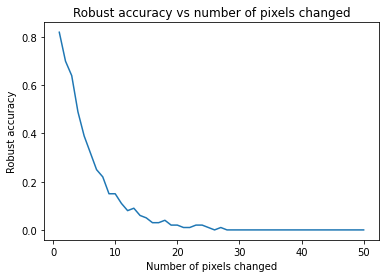

In [282]:
robust_acc_pgd_l0 = np.array(robust_acc_pgd_l0)
plt.plot(robust_acc_pgd_l0[:,0], robust_acc_pgd_l0[:,1])
plt.xlabel('Number of pixels changed')
plt.ylabel('Robust accuracy')
plt.title('Robust accuracy vs number of pixels changed for PGD attack with L0 norm')
plt.show()

In [364]:
modified_pixel_images_PGD = []
modified_pixel_images_PGD = np.zeros((100, 32, 32, 3))
for i in range(100):
    modified_pixel_images_PGD[i] = X_test[i] * (1 - adv_PGD[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD attack with l0 norm (k=5)


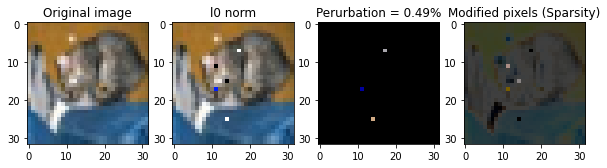

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


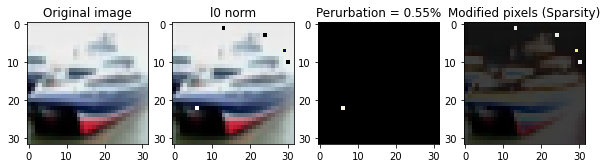

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


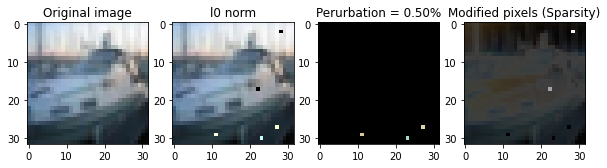

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


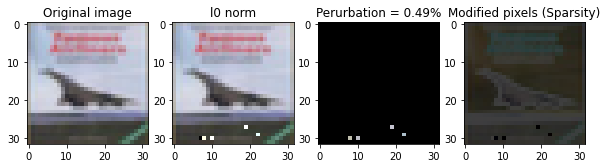

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


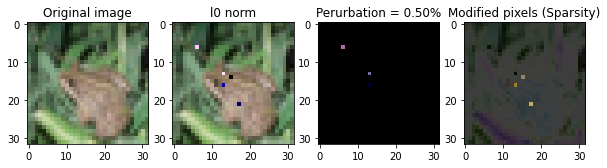

In [366]:
print('PGD attack with l0 norm (k=5)')
for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(adv_PGD[i])
    plt.title('l0 norm')
    plt.subplot(1,4,3)
    plt.imshow(adv_PGD[i]-X_test[i])
    perturbation_percentage = np.sum(np.abs(adv_PGD[i]-X_test[i])>0.1)/np.sum(np.abs(X_test[i])>0.1)
    plt.title('Perurbation = ' + '{:.2f}'.format(perturbation_percentage*100) + '%')
    plt.subplot(1,4,4)
    plt.imshow(modified_pixel_images_PGD[i])
    plt.title('Modified pixels (Sparsity)')
    plt.show()

### PGD attack with L0+Linf norm with k = 5 pixels

In [275]:
args = {'type_attack': 'L0+Linf',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.1,
                'sparsity': 5}
attack = PGDattack(model, args)
adv_PGD_2, pixels_changed_PGD_2, pgd_adv_acc_PGD_2 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_PGD_2.npy', adv_PGD_2)

Restart 1 - Robust accuracy: 0.76
Restart 2 - Robust accuracy: 0.76
Restart 3 - Robust accuracy: 0.76
Restart 4 - Robust accuracy: 0.74
Restart 5 - Robust accuracy: 0.74
Pixels changed:  [0 0 5 5 0 0 0 0 5 0 0 0 0 0 0 5 0 0 0 0 5 0 5 0 0 0 5 0 0 0 0 0 5 0 0 5 0
 5 0 0 0 0 5 0 0 0 5 5 0 0 0 0 5 5 0 0 0 5 5 5 0 5 0 0 0 0 0 0 0 0 5 0 0 0
 0 0 0 0 5 0 0 0 0 0 5 5 0 5 0 0 0 0 0 0 0 5 0 5 0 0]
Robust accuracy at 5 pixels: 74.00%
Maximum perturbation size: 0.10000


### PGD attack with L0+Linf norm with k = 10 pixels

In [283]:
args = {'type_attack': 'L0+Linf',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.1,
                'sparsity': 10}
attack = PGDattack(model, args)
adv_PGD_2_k10, pixels_changed_PGD_2_k10, pgd_adv_acc_PGD_2_k10 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_PGD_2_k10.npy', adv_PGD_2_k10)

Restart 1 - Robust accuracy: 0.66
Restart 2 - Robust accuracy: 0.64
Restart 3 - Robust accuracy: 0.64
Restart 4 - Robust accuracy: 0.62
Restart 5 - Robust accuracy: 0.6
Pixels changed:  [10  0 10 10  0  0  0 10 10  0  0  0 10  0  0 10  0  0  0  0 10  0 10  0
 10  0 10  0  0  0 10 10 10 10  0 10  0 10  0  0  0  0 10  0  0  0 10 10
  0 10  0  0 10 10 10  0  0 10 10 10  0 10  0 10  0  0  0  0 10  0 10  0
  0  0  0  0  0  0 10  0  0  0  0  0 10 10  0 10  0  0  0 10  0  0 10 10
 10 10  0  0]
Robust accuracy at 10 pixels: 60.00%
Maximum perturbation size: 0.10000


### PGD attack with L0+Linf norm with changing pixels from 1-50 with n-restarts = 1

In [284]:
robust_acc_pgd_l0_linf = []
for k in range(1, 51):
    args = {'type_attack': 'L0+Linf',
                  'n_restarts': 1,
                  'num_steps': 100,
                  'step_size': 120000.0/255.0,
                  'kappa': -1,
                  'epsilon': 0.1,
                  'sparsity': k}
    attack = PGDattack(model, args)
    adv_val, pixels_changed_PGD_val, pgd_adv_acc_PGD_val = attack.perturb(X_test, y_test)
    robust_acc_pgd_l0_linf.append((k, np.sum(pgd_adv_acc_PGD_val)/X_test.shape[0]))

Restart 1 - Robust accuracy: 0.88
Pixels changed:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Robust accuracy at 1 pixels: 88.00%
Maximum perturbation size: 0.10000
Restart 1 - Robust accuracy: 0.84
Pixels changed:  [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 2 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
Robust accuracy at 2 pixels: 84.00%
Maximum perturbation size: 0.10000
Restart 1 - Robust accuracy: 0.83
Pixels changed:  [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 3 0 0 0 0 3 0 0 0 0 3 0 0 0 0 3 3 0 0 0 3 3 3 0 3 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
Robust accuracy at 3 pixels: 83.00%
Maximum perturbation size: 0.10000
Restart 1 - Robust acc

### Plotting the robust accuracy vs number of pixels changed for PGD attack with L0+Linf norm

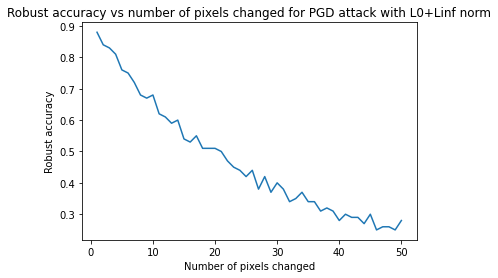

In [285]:
robust_acc_pgd_l0_linf = np.array(robust_acc_pgd_l0_linf)
plt.plot(robust_acc_pgd_l0_linf[:,0], robust_acc_pgd_l0_linf[:,1])
plt.xlabel('Number of pixels changed')
plt.ylabel('Robust accuracy')
plt.title('Robust accuracy vs number of pixels changed for PGD attack with L0+Linf norm')
plt.show()

In [367]:
modified_pixel_images_PGD_2_k10 = []
modified_pixel_images_PGD_2_k10 = np.zeros((100, 32, 32, 3))
for i in range(100):
    modified_pixel_images_PGD_2_k10[i] = X_test[i] * (1 - adv_PGD_2_k10[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD attack with l0+linf norm (k=10)


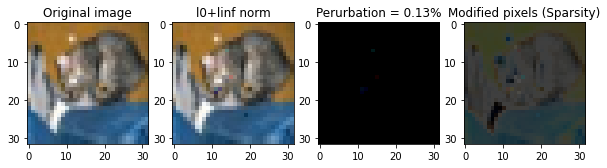

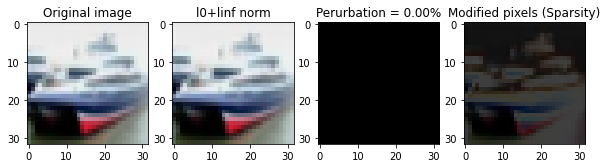

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


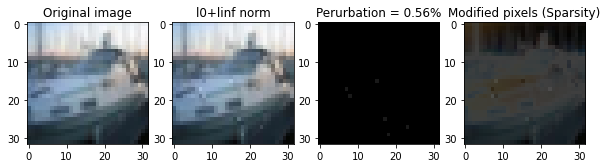

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


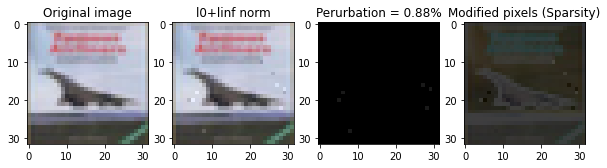

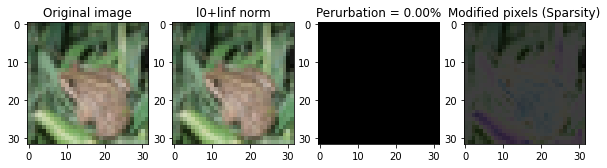

In [368]:
print('PGD attack with l0+linf norm (k=10)')

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(adv_PGD_2_k10[i])
    plt.title('l0+linf norm')
    plt.subplot(1,4,3)
    plt.imshow(adv_PGD_2_k10[i]-X_test[i], cmap='Blues')
    perturbation_percentage = np.sum(np.abs(adv_PGD_2_k10[i]-X_test[i])>0.1)/np.sum(np.abs(X_test[i])>0.1)
    plt.title('Perurbation = ' + '{:.2f}'.format(perturbation_percentage*100) + '%')
    plt.subplot(1,4,4)
    plt.imshow(modified_pixel_images_PGD_2_k10[i])
    plt.title('Modified pixels (Sparsity)')
    plt.show()

### PGD attack with L0+sigma norm with k = 5 pixels

In [277]:
args = {'type_attack': 'L0+sigma',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': 1,
                'epsilon': -1,
                'sparsity': 5}
attack = PGDattack(model, args)
adv_PGD_3, pixels_changed_PGD_3, pgd_adv_acc_PGD_3 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_PGD_3.npy', adv_PGD_3)

Restart 1 - Robust accuracy: 0.81
Restart 2 - Robust accuracy: 0.8
Restart 3 - Robust accuracy: 0.78
Restart 4 - Robust accuracy: 0.77
Restart 5 - Robust accuracy: 0.77
Pixels changed:  [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 5 0 0 0 5 0 0 0 0 0 5 0 0 5 0
 5 0 0 0 0 5 0 0 0 5 5 0 0 0 0 5 5 0 0 0 5 5 5 0 5 0 0 0 0 0 0 0 0 5 0 0 0
 0 0 0 0 5 0 0 0 0 0 5 5 5 5 0 0 0 0 0 0 0 5 0 0 0 0]
Robust accuracy at 5 pixels: 77.00%
Maximum perturbation size: 0.30313


### PGD attack with L0+sigma norm with k = 10 pixels

In [286]:
args = {'type_attack': 'L0+sigma',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': 1,
                'epsilon': -1,
                'sparsity': 10}
attack = PGDattack(model, args)
adv_PGD_3_k10, pixels_changed_PGD_3_k10, pgd_adv_acc_PGD_3_k10 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_PGD_3_k10.npy', adv_PGD_3_k10)

Restart 1 - Robust accuracy: 0.61
Restart 2 - Robust accuracy: 0.61
Restart 3 - Robust accuracy: 0.6
Restart 4 - Robust accuracy: 0.6
Restart 5 - Robust accuracy: 0.6
Pixels changed:  [10  0 10 10  0  0  0 10  0 10  0  0 10  0  0 10 10  0  0  0 10  0 10  0
 10  0 10  0  0  0  0  0 10  0  0 10  0 10  0  0  0  0 10  0  0  0 10 10
  0 10  0  0 10 10  0  0  0 10 10 10  0 10  0 10  0  0  0  0 10 10 10 10
  0  0  0  0  0  0 10  0  0  0  0 10 10 10 10 10  0  0  0 10  0  0 10 10
 10  0  0  0]
Robust accuracy at 10 pixels: 60.00%
Maximum perturbation size: 0.32860


### PGD attack with L0+sigma norm with changing pixels from 1-50 with n-restarts = 1

In [287]:
robust_acc_pgd_l0_sigma = []
for k in range(1, 51):
    args = {'type_attack': 'L0+sigma',
                  'n_restarts': 1,
                  'num_steps': 100,
                  'step_size': 120000.0/255.0,
                  'kappa': 1,
                  'epsilon': -1,
                  'sparsity': k}
    attack = PGDattack(model, args)
    adv_val, pixels_changed_PGD_val, pgd_adv_acc_PGD_val = attack.perturb(X_test, y_test)
    robust_acc_pgd_l0_sigma.append((k, np.sum(pgd_adv_acc_PGD_val)/X_test.shape[0]))

Restart 1 - Robust accuracy: 0.89
Pixels changed:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Robust accuracy at 1 pixels: 89.00%
Maximum perturbation size: 0.24093
Restart 1 - Robust accuracy: 0.86
Pixels changed:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 2 0 0 0 2 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
Robust accuracy at 2 pixels: 86.00%
Maximum perturbation size: 0.26136
Restart 1 - Robust accuracy: 0.85
Pixels changed:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 3 0 0 0 3 3 3 0 3 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 3 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0]
Robust accuracy at 3 pixels: 85.00%
Maximum perturbation size: 0.37001
Restart 1 - Robust acc

### Plotting the robust accuracy vs number of pixels changed for PGD attack with L0+sigma norm

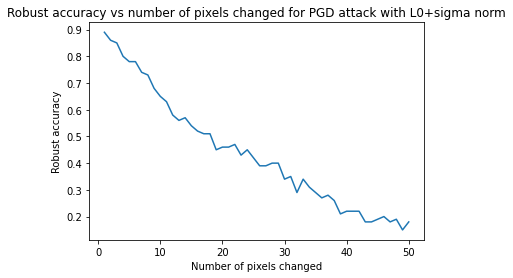

In [288]:
robust_acc_pgd_l0_sigma = np.array(robust_acc_pgd_l0_sigma)
plt.plot(robust_acc_pgd_l0_sigma[:,0], robust_acc_pgd_l0_sigma[:,1])
plt.xlabel('Number of pixels changed')
plt.ylabel('Robust accuracy')
plt.title('Robust accuracy vs number of pixels changed for PGD attack with L0+sigma norm')
plt.show()

In [369]:
modified_pixel_images_PGD_3_k10 = []
modified_pixel_images_PGD_3_k10 = np.zeros((100, 32, 32, 3))

for i in range(100):
    modified_pixel_images_PGD_3_k10[i] = X_test[i] * (1 - adv_PGD_3_k10[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD attack with l0+sigma norm (k=10)


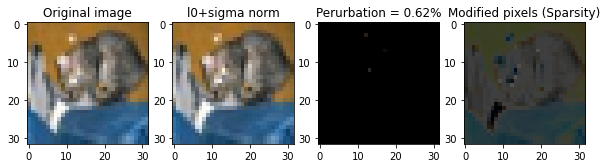

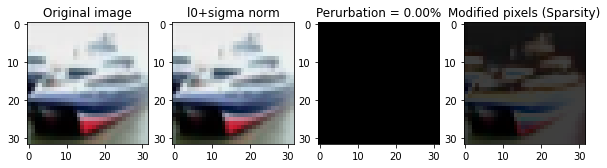

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


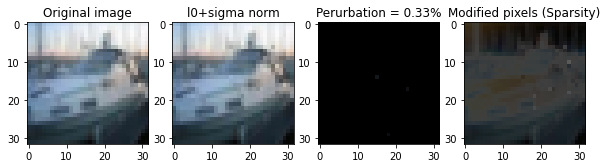

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


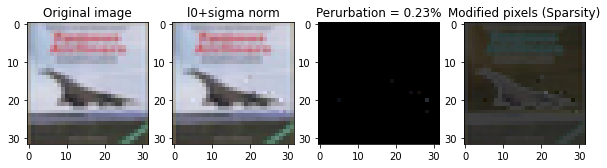

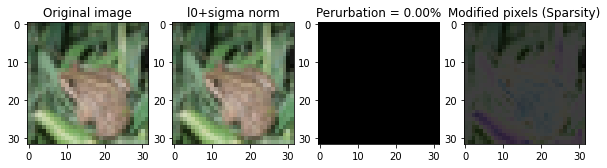

In [370]:
print('PGD attack with l0+sigma norm (k=10)')

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(adv_PGD_3_k10[i])
    plt.title('l0+sigma norm')
    plt.subplot(1,4,3)
    plt.imshow(adv_PGD_3_k10[i]-X_test[i])
    perturbation_percentage = np.sum(np.abs(adv_PGD_3_k10[i]-X_test[i])>0.1)/np.sum(np.abs(X_test[i])>0.1)
    plt.title('Perurbation = ' + '{:.2f}'.format(perturbation_percentage*100) + '%')
    plt.subplot(1,4,4)
    plt.imshow(modified_pixel_images_PGD_3_k10[i])
    plt.title('Modified pixels (Sparsity)')
    plt.show()

### Clearing the GPU cache

In [278]:
torch.cuda.empty_cache() 

### CornerSearch attack with L0 norm with k = 10 pixels

In [251]:
args = {'type_attack': 'L0',
            'n_iter': 1000,
            'n_max': 100,
            'kappa': -1,
            'epsilon': -1,
            'sparsity': 10,
            'size_incr': 1}

attack = CSattack(model, args)
adv_CS, pixel_changed_CS, fl_success_CS = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_CS.npy', adv_CS)

Point 0 - adversarial example found changing 2 pixels
Point 1 - adversarial example found changing 3 pixels
Point 2 - adversarial example found changing 1 pixel
Point 3 - adversarial example found changing 2 pixels
Point 4 - adversarial example found changing 2 pixels
Point 5 - adversarial example found changing 2 pixels
Point 6 - adversarial example found changing 2 pixels
Point 7 - adversarial example found changing 1 pixel
Point 8 - adversarial example found changing 1 pixel
Point 9 - adversarial example found changing 2 pixels
Point 10 - adversarial example found changing 2 pixels
Point 11 - adversarial example not found
Point 12 - adversarial example found changing 2 pixels
Point 13 - adversarial example found changing 3 pixels
Point 14 - adversarial example found changing 5 pixels
Point 15 - adversarial example found changing 1 pixel
Point 16 - adversarial example found changing 2 pixels
Point 17 - adversarial example found changing 2 pixels
Point 18 - adversarial example found c

In [371]:
modified_pixel_images_CS = []
modified_pixel_images_CS = np.zeros((100, 32, 32, 3))

for i in range(100):
    modified_pixel_images_CS[i] = X_test[i] * (1 - adv_CS[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CS attack with l0 norm (k=10)


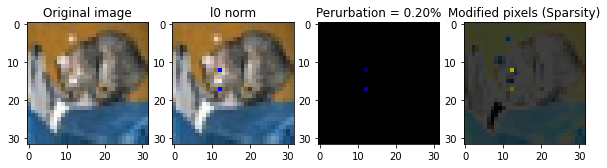

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


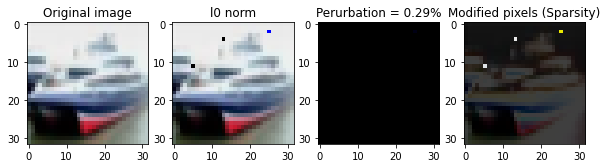

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


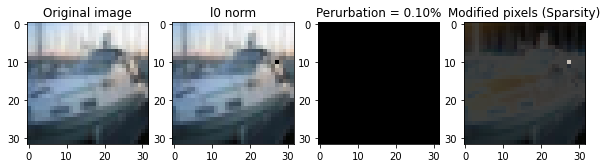

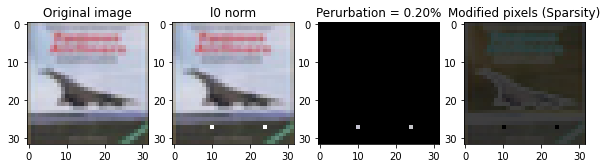

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


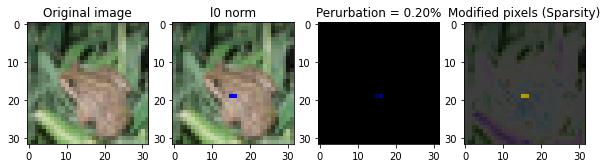

In [372]:
print('CS attack with l0 norm (k=10)')

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(adv_CS[i])
    plt.title('l0 norm')
    plt.subplot(1,4,3)
    plt.imshow(adv_CS[i]-X_test[i])
    perturbation_percentage = np.sum(np.abs(adv_CS[i]-X_test[i])>0.1)/np.sum(np.abs(X_test[i])>0.1)
    plt.title('Perurbation = ' + '{:.2f}'.format(perturbation_percentage*100) + '%')
    plt.subplot(1,4,4)
    plt.imshow(modified_pixel_images_CS[i])
    plt.title('Modified pixels (Sparsity)')
    plt.show()

### CornerSearch attack with L0+inf norm

In [256]:
args = {'type_attack': 'L0+Linf',
            'n_iter': 1000,
            'n_max': 100,
            'kappa': -1,
            'epsilon': -1,
            'sparsity': 10,
            'size_incr': 1}

attack = CSattack(model, args)
adv_CS_2, pixel_changed_CS_2, fl_success_CS_2 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_CS_2.npy', adv_CS_2)

Point 0 - adversarial example found changing 2 pixels
Point 1 - adversarial example found changing 3 pixels
Point 2 - adversarial example found changing 1 pixel
Point 3 - adversarial example found changing 2 pixels
Point 4 - adversarial example found changing 2 pixels
Point 5 - adversarial example found changing 2 pixels
Point 6 - adversarial example found changing 2 pixels
Point 7 - adversarial example found changing 1 pixel
Point 8 - adversarial example found changing 1 pixel
Point 9 - adversarial example found changing 2 pixels
Point 10 - adversarial example found changing 2 pixels
Point 11 - adversarial example not found
Point 12 - adversarial example found changing 2 pixels
Point 13 - adversarial example found changing 3 pixels
Point 14 - adversarial example found changing 5 pixels
Point 15 - adversarial example found changing 1 pixel
Point 16 - adversarial example found changing 2 pixels
Point 17 - adversarial example found changing 2 pixels
Point 18 - adversarial example found c

In [373]:
modified_pixel_images_CS_2 = []
modified_pixel_images_CS_2 = np.zeros((100, 32, 32, 3))

for i in range(100):
    modified_pixel_images_CS_2[i] = X_test[i] * (1 - adv_CS_2[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CS attack with l0+Linf norm (k=10)


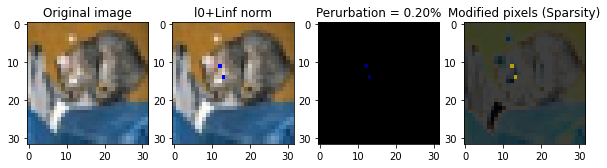

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


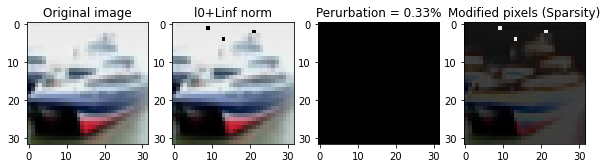

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


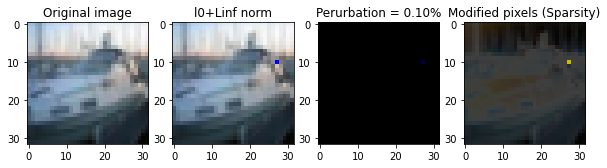

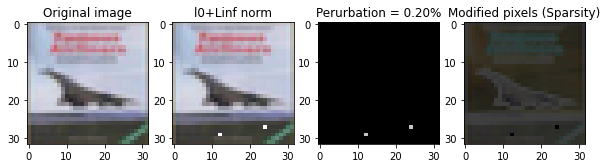

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


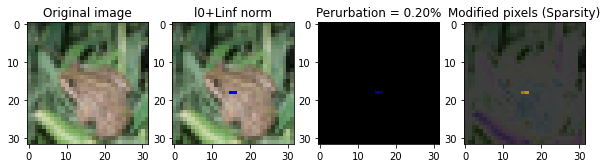

In [374]:
print('CS attack with l0+Linf norm (k=10)')

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(adv_CS_2[i])
    plt.title('l0+Linf norm')
    plt.subplot(1,4,3)
    plt.imshow(adv_CS_2[i]-X_test[i])
    perturbation_percentage = np.sum(np.abs(adv_CS_2[i]-X_test[i])>0.1)/np.sum(np.abs(X_test[i])>0.1)
    plt.title('Perurbation = ' + '{:.2f}'.format(perturbation_percentage*100) + '%')
    plt.subplot(1,4,4)
    plt.imshow(modified_pixel_images_CS_2[i])
    plt.title('Modified pixels (Sparsity)')
    plt.show()

### CornerSearch attack with L0+sigma norm

In [258]:
args = {'type_attack': 'L0+sigma',
            'n_iter': 1000,
            'n_max': 100,
            'kappa': 1,
            'epsilon': -1,
            'sparsity': 10,
            'size_incr': 1}

attack = CSattack(model, args)
adv_CS_3, pixel_changed_CS_3, fl_success_CS_3 = attack.perturb(X_test, y_test)

# Save the results in the results folder
np.save('./results/adv_CS_3.npy', adv_CS_3)

Point 0 - adversarial example found changing 3 pixels
Point 1 - adversarial example found changing 10 pixels
Point 2 - adversarial example found changing 2 pixels
Point 3 - adversarial example found changing 6 pixels
Point 4 - adversarial example not found
Point 5 - adversarial example found changing 10 pixels
Point 6 - adversarial example found changing 6 pixels
Point 7 - adversarial example found changing 2 pixels
Point 8 - adversarial example found changing 2 pixels
Point 9 - adversarial example found changing 5 pixels
Point 10 - adversarial example found changing 6 pixels
Point 11 - adversarial example not found
Point 12 - adversarial example found changing 3 pixels
Point 13 - adversarial example not found
Point 14 - adversarial example not found
Point 15 - adversarial example found changing 1 pixel
Point 16 - adversarial example found changing 6 pixels
Point 17 - adversarial example found changing 4 pixels
Point 18 - adversarial example not found
Point 19 - adversarial example not

In [375]:
modified_pixel_images_CS_3 = []
modified_pixel_images_CS_3 = np.zeros((100, 32, 32, 3))

for i in range(100):
    modified_pixel_images_CS_3[i] = X_test[i] * (1 - adv_CS_3[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CS attack with l0+sigma norm (k=10)


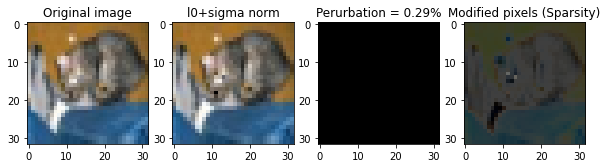

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


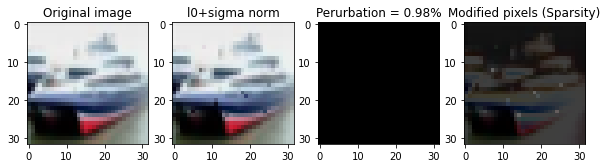

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


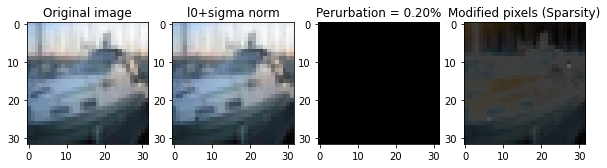

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


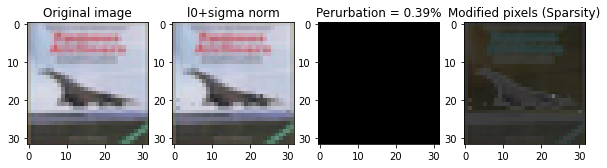

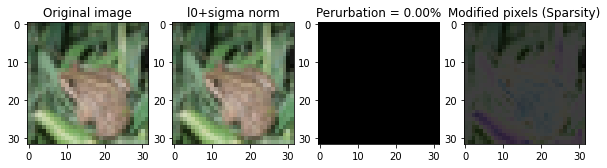

In [376]:
print('CS attack with l0+sigma norm (k=10)')

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title('Original image')
    plt.subplot(1,4,2)
    plt.imshow(adv_CS_3[i])
    plt.title('l0+sigma norm')
    plt.subplot(1,4,3)
    plt.imshow(adv_CS_3[i]-X_test[i])
    perturbation_percentage = np.sum(np.abs(adv_CS_3[i]-X_test[i])>0.1)/np.sum(np.abs(X_test[i])>0.1)
    plt.title('Perurbation = ' + '{:.2f}'.format(perturbation_percentage*100) + '%')
    plt.subplot(1,4,4)
    plt.imshow(modified_pixel_images_CS_3[i])
    plt.title('Modified pixels (Sparsity)')
    plt.show()

---

### Running attacks on the models with FashionMNIST dataset and evaluating the results with with 1000 test samples.

In [57]:
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)

In [58]:
print("Train data shape: ", train_loader.dataset.train_data.shape)
print("Train labels shape: ", train_loader.dataset.train_labels.shape)

Train data shape:  torch.Size([60000, 28, 28])
Train labels shape:  torch.Size([60000])


In [53]:
X_test_Fashion, y_test_Fashion = load_data(dataset = 'FashionMNIST', data_dir = 'data', n_examples=1000)

print('X_test_Fashion shape: ', X_test_Fashion.shape)
print('y_test_Fashion shape: ', y_test_Fashion.shape)

X_test_Fashion shape:  (1000, 28, 28, 3)
y_test_Fashion shape:  (1000,)


In [54]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5, padding=1) # Number of filters in the first convolutional layer = 10
        nn.init.kaiming_normal_(self.conv1.weight) # Initializing the weights of the first convolutional layer using Kaiming Normal Initialization also known as He Normal Initialization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=5, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(
            in_channels=20, out_channels=40, kernel_size=5, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(
            in_channels=40, out_channels=64, kernel_size=5, padding=1)
        nn.init.kaiming_normal_(self.conv4.weight)
        
        self.fc = nn.Linear(in_features=64 * 10 * 10, out_features=256)
        nn.init.kaiming_normal_(self.fc.weight)
        self.fc_out = nn.Linear(in_features=256, out_features=10)
        nn.init.kaiming_normal_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # Applying ReLU activation function
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc(x))
        x = self.fc_out(x) 
        return x

In [55]:
model_Fashion = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Fashion.parameters(), lr=0.001)

In [59]:
def train_model(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss/len(train_loader)
        avg_accuracy = correct/len(train_loader.dataset)
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        print("Epoch:", epoch+1, "Training Loss: ", avg_loss, "\t Training Accuracy: ", avg_accuracy)
    print("Training complete!")
    return train_loss, train_accuracy

In [60]:
train_loss = []
train_accuracy = []
train_loss, train_accuracy = train_model(model_Fashion, optimizer, 15, train_loss, train_accuracy)

Epoch: 1 Training Loss:  0.4045677246378937 	 Training Accuracy:  0.8556833333333334
Epoch: 2 Training Loss:  0.24917818224633426 	 Training Accuracy:  0.9097166666666666
Epoch: 3 Training Loss:  0.19884255785804822 	 Training Accuracy:  0.9258333333333333
Epoch: 4 Training Loss:  0.16027844257986368 	 Training Accuracy:  0.9413333333333334
Epoch: 5 Training Loss:  0.12473825990422957 	 Training Accuracy:  0.9546166666666667
Epoch: 6 Training Loss:  0.09953737123084984 	 Training Accuracy:  0.9628666666666666
Epoch: 7 Training Loss:  0.07603272894171001 	 Training Accuracy:  0.9714833333333334
Epoch: 8 Training Loss:  0.0576640961459403 	 Training Accuracy:  0.9794166666666667
Epoch: 9 Training Loss:  0.04605048209397015 	 Training Accuracy:  0.9828333333333333
Epoch: 10 Training Loss:  0.03901981207718854 	 Training Accuracy:  0.9852666666666666
Epoch: 11 Training Loss:  0.03305907384492457 	 Training Accuracy:  0.9876166666666667
Epoch: 12 Training Loss:  0.031000574929580124 	 Train

### PGD attack with L0 norm with k = 5 pixels

In [63]:
args = {'type_attack': 'L0',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': -1,
                'sparsity': 5}

attack = PGDattack(model_Fashion, args)

adv_PGD_Fashion = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_PGD_Fashion.npy', adv_PGD_Fashion)

### PGD attack with L0 norm with k = 10 pixels

In [ ]:
args = {'type_attack': 'L0',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': -1,
                'sparsity': 10}

attack = PGDattack(model_Fashion, args)

adv_PGD_Fashion_10 = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_PGD_Fashion_10.npy', adv_PGD_Fashion_10)

### PGD attack with L0 norm with changing pixels from 1-50 with n-restarts = 1

In [ ]:
robust_acc_pgd_l0_Fashion = []
for i in range(1, 51):
    args = {'type_attack': 'L0',
                'n_restarts': 1,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': -1,
                'sparsity': i}
    attack = PGDattack(model_Fashion, args)
    adv_val, pixels_changed_PGD_val, pgd_adv_acc_PGD_val = attack.perturb(X_test_Fashion, y_test_Fashion)
    robust_acc_pgd_l0_Fashion.append((k, np.sum(pgd_adv_acc_PGD_val)/X_test_Fashion.shape[0]))

### PGD attack with L0+Linf norm with k = 5 pixels

In [ ]:
args = {'type_attack': 'L0+Linf',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.3,
                'sparsity': 5}

attack = PGDattack(model_Fashion, args)
adv_PGD_l0_linf_Fashion, pixels_changed_PGD_l0_linf_Fashion, pgd_adv_acc_PGD_l0_linf_Fashion = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_PGD_l0_linf_Fashion.npy', adv_PGD_l0_linf_Fashion)

### PGD attack with L0+Linf norm with k = 10 pixels

In [ ]:
args = {'type_attack': 'L0+Linf',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.3,
                'sparsity': 10}

attack = PGDattack(model_Fashion, args)
adv_PGD_l0_linf_Fashion_10, pixels_changed_PGD_l0_linf_Fashion_10, pgd_adv_acc_PGD_l0_linf_Fashion_10 = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_PGD_l0_linf_Fashion_10.npy', adv_PGD_l0_linf_Fashion_10)

### PGD attack with L0+Linf norm with changing pixels from 1-50 with n-restarts = 1

In [ ]:
robust_acc_pgd_l0_linf_Fashion = []
for i in range(1, 51):
    args = {'type_attack': 'L0+Linf',
                'n_restarts': 1,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.3,
                'sparsity': i}
    attack = PGDattack(model_Fashion, args)
    adv_val, pixels_changed_PGD_val, pgd_adv_acc_PGD_val = attack.perturb(X_test_Fashion, y_test_Fashion)
    robust_acc_pgd_l0_linf_Fashion.append((k, np.sum(pgd_adv_acc_PGD_val)/X_test_Fashion.shape[0]))

### PGD attack with L0+sigma norm with k = 5 pixels

In [ ]:
args = {'type_attack': 'L0+sigma',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.3,
                'sparsity': 5}

attack = PGDattack(model_Fashion, args)
adv_PGD_l0_sigma_Fashion, pixels_changed_PGD_l0_sigma_Fashion, pgd_adv_acc_PGD_l0_sigma_Fashion = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_PGD_l0_sigma_Fashion.npy', adv_PGD_l0_sigma_Fashion)

### PGD attack with L0+sigma norm with k = 10 pixels

In [ ]:
args = {'type_attack': 'L0+sigma',
                'n_restarts': 5,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.3,
                'sparsity': 10}

attack = PGDattack(model_Fashion, args)
adv_PGD_l0_sigma_Fashion_10, pixels_changed_PGD_l0_sigma_Fashion_10, pgd_adv_acc_PGD_l0_sigma_Fashion_10 = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_PGD_l0_sigma_Fashion_10.npy', adv_PGD_l0_sigma_Fashion_10)

### PGD attack with L0+sigma norm with changing pixels from 1-50 with n-restarts = 1

In [ ]:
robust_acc_pgd_l0_sigma_Fashion = []
for i in range(1, 51):
    args = {'type_attack': 'L0+sigma',
                'n_restarts': 1,
                'num_steps': 100,
                'step_size': 120000.0/255.0,
                'kappa': -1,
                'epsilon': 0.3,
                'sparsity': i}
    attack = PGDattack(model_Fashion, args)
    adv_val, pixels_changed_PGD_val, pgd_adv_acc_PGD_val = attack.perturb(X_test_Fashion, y_test_Fashion)
    robust_acc_pgd_l0_sigma_Fashion.append((k, np.sum(pgd_adv_acc_PGD_val)/X_test_Fashion.shape[0]))

### Clearing the GPU cache

In [64]:
torch.cuda.empty_cache()

### CornerSearch attack with L0 norm with k = 10 pixels

In [ ]:
args = {'type_attack': 'L0',
            'n_iter': 1000,
            'n_max': 100,
            'kappa': -1,
            'epsilon': -1,
            'sparsity': 10,
            'size_incr': 1}

attack = CSattack(model_Fashion, args)
adv_CS_l0_Fashion, pixels_changed_CS_l0_Fashion, cs_adv_acc_CS_l0_Fashion = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_CS_l0_Fashion.npy', adv_CS_l0_Fashion)

### CornerSearch attack with L0+inf norm

In [ ]:
args = {'type_attack': 'L0+Linf',
            'n_iter': 1000,
            'n_max': 100,
            'kappa': -1,
            'epsilon': -1,
            'sparsity': 10,
            'size_incr': 1}

attack = CSattack(model_Fashion, args)
adv_CS_l0_linf_Fashion, pixels_changed_CS_l0_linf_Fashion, cs_adv_acc_CS_l0_linf_Fashion = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_CS_l0_linf_Fashion.npy', adv_CS_l0_linf_Fashion)

### CornerSearch attack with L0+sigma norm

In [ ]:
args = {'type_attack': 'L0+sigma',
            'n_iter': 1000,
            'n_max': 100,
            'kappa': 1,
            'epsilon': -1,
            'sparsity': 10,
            'size_incr': 1}

attack = CSattack(model_Fashion, args)
adv_CS_l0_sigma_Fashion, pixels_changed_CS_l0_sigma_Fashion, cs_adv_acc_CS_l0_sigma_Fashion = attack.perturb(X_test_Fashion, y_test_Fashion)

np.save('./results/adv_CS_l0_sigma_Fashion.npy', adv_CS_l0_sigma_Fashion)

---